In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from qutip import (
    basis, mesolve, sigmax, sigmay, sigmaz, qeye, tensor, Options, expect
)
from tqdm import tqdm # 用于显示进度条
%matplotlib widget
# --- (字体配置与之前相同) ---
try:
    font_preferences = ['SimHei', 'Microsoft YaHei', 'WenQuanYi Micro Hei', 'PingFang SC', 'Noto Sans CJK SC']
    found_font = False
    for font_name in font_preferences:
        try:
            matplotlib.font_manager.findfont(font_name)
            plt.rcParams['font.sans-serif'] = [font_name]
            print(f"中文配置：成功设置字体为 {font_name}")
            found_font = True
            break
        except Exception:
            continue
    if not found_font:
        print("中文配置：未能找到并设置优先选择的中文字体。中文可能无法正确显示。")
    plt.rcParams['axes.unicode_minus'] = False
except Exception as e:
    print(f"设置Matplotlib字体参数时发生错误: {e}")

中文配置：成功设置字体为 SimHei


In [2]:
# --- (Qobj 定义) ---
g_state = basis(2, 0)
e_state = basis(2, 1)
ge = tensor(g_state, e_state)
eg = tensor(e_state, g_state)
# 定义单比特算符
sx1_op = tensor(sigmax(), qeye(2))
sy1_op = tensor(sigmay(), qeye(2))
sz1_op = tensor(sigmaz(), qeye(2))
sx2_op = tensor(qeye(2), sigmax())
sy2_op = tensor(qeye(2), sigmay())
sz2_op = tensor(qeye(2), sigmaz())
I4 = tensor(qeye(2), qeye(2))
# 定义双比特算符
sxsx_op = tensor(sigmax(), sigmax())
sysy_op = tensor(sigmay(), sigmay())
szsz_op = tensor(sigmaz(), sigmaz())
# 定义初始态
psi_p_single = (g_state + e_state).unit()
psi_p_initial = tensor(psi_p_single, psi_p_single)
rho_initial = psi_p_initial * psi_p_initial.dag()
# 定义一些态
psi_plus = (ge + eg).unit()
P_psi_plus_op = psi_plus * psi_plus.dag() # 重命名以区分变量和字符串
psi_minus = (ge - eg).unit()
P_psi_minus_op = psi_minus * psi_minus.dag() # 重命名
#DFS子空间
P01_op = ge * ge.dag() # 重命名
P10_op = eg * eg.dag() # 重命名


In [14]:
# --- 系统参数 ---
delta_drive_H = 1.0 * np.pi  # 主驱动哈密顿量的强度
H_drive_base = (delta_drive_H / 2.0) * (sz1_op + sz2_op) # 驱动的基础部分

delta_omega_DFS = 0.1 * np.pi # DFS子空间内|01>和|10>的能量劈裂
H_bias_DFS = (delta_omega_DFS / 2.0) * (P01_op - P10_op)

# 哈密顿量的固定部分
H_fixed_part = H_drive_base + H_bias_DFS

# --- 准静态集体噪声参数 ---
N_quasi_static_samples = 200  # 采样的噪声实例数量 (为了速度，可以先设小一点，如10-50)
sigma_quasi_static_noise_strength = 0.1 * np.pi # 准静态噪声的标准差 (与delta_drive_H可比拟)
# 准静态噪声算符 (集体 Z 型噪声)
H_quasi_static_operator = (sz1_op + sz2_op) / 2.0 # 除以2是为了与上面的能量单位一致

# --- 其他退相干参数 (动态噪声) ---
gamma_collective_rate = 0.002        # 原有的集体退相干率 (动态)
gamma_DFS_dephasing_rate = 0   # 原有的DFS内部退相干率 (动态)

# --- 时间参数 ---
t_final = 100.0
t_pulse = t_final / 2.0
n_points_segment = 150 # 保持和之前一致以方便比较
tlist_full = np.linspace(0, t_final, 2 * n_points_segment + 1)
pulse_idx = np.argmin(np.abs(tlist_full - t_pulse))
t_pulse_actual = tlist_full[pulse_idx]

In [15]:
# --- QuTiP 选项 ---
qutip_options_store_states = Options(store_states=True, nsteps=5000, atol=1e-7, rtol=1e-5) # 稍微放宽容忍度
qutip_options_no_store = Options(store_states=False, nsteps=5000, atol=1e-7, rtol=1e-5)


# --- 期望算符列表 (与之前相同) ---
e_ops_to_track = [
    sx1_op, sy1_op, sz1_op,
    sx2_op, sy2_op, sz2_op,
    P_psi_plus_op, P_psi_minus_op,
    sxsx_op, sysy_op, szsz_op,
    P01_op, P10_op
]
num_e_ops = len(e_ops_to_track)

# --- 塌缩算符 (动态噪声部分，与之前相同) ---
c_ops_dynamic = []
if gamma_collective_rate > 0:
    c_op_main_collective = np.sqrt(gamma_collective_rate) * (sz1_op + sz2_op)
    c_ops_dynamic.append(c_op_main_collective)
if gamma_DFS_dephasing_rate > 0:
    c_op_DFS_internal_dephasing = np.sqrt(gamma_DFS_dephasing_rate) * (sz1_op - sz2_op)
    c_ops_dynamic.append(c_op_DFS_internal_dephasing)


In [16]:
# --- 模拟计算，包含准静态噪声平均 ---

# 初始化用于存储平均期望值的数组
avg_result_no_echo_expect = [np.zeros_like(tlist_full, dtype=float) for _ in range(num_e_ops)]
avg_results_echo_expect = [np.zeros_like(tlist_full, dtype=float) for _ in range(num_e_ops)]

print(f"开始模拟，包含 {N_quasi_static_samples} 个准静态噪声样本...")

for k_sample in tqdm(range(N_quasi_static_samples), desc="准静态噪声采样"):
    # 1. 为当前样本生成一个随机的准静态噪声强度
    epsilon_k = np.random.normal(0, sigma_quasi_static_noise_strength)
    H_noise_instance = epsilon_k * H_quasi_static_operator
    H_total_current_sample = H_fixed_part + H_noise_instance

    # 2. 模拟：无回波
    result_no_echo_k = mesolve(H_total_current_sample, rho_initial, tlist_full, c_ops_dynamic, e_ops_to_track, options=qutip_options_no_store)
    for i in range(num_e_ops):
        avg_result_no_echo_expect[i] += result_no_echo_k.expect[i]

    # 3. 模拟：有回波
    tlist_part1 = tlist_full[:pulse_idx + 1]
    result_part1_k = mesolve(H_total_current_sample, rho_initial, tlist_part1, c_ops_dynamic, e_ops_to_track, options=qutip_options_store_states)
    rho_at_pulse_k = result_part1_k.states[-1]

    U_pi_pulse = tensor(sigmay(), sigmay()) # Pi脉冲
    rho_after_pulse_k = U_pi_pulse * rho_at_pulse_k * U_pi_pulse.dag()

    tlist_part2_relative = tlist_full[pulse_idx:] - t_pulse_actual
    result_part2_k = mesolve(H_total_current_sample, rho_after_pulse_k, tlist_part2_relative, c_ops_dynamic, e_ops_to_track, options=qutip_options_no_store)

    for i in range(num_e_ops):
        combined_expect_k = np.concatenate((result_part1_k.expect[i][:-1], result_part2_k.expect[i]))
        avg_results_echo_expect[i] += combined_expect_k

# --- 计算平均值 ---
for i in range(num_e_ops):
    avg_result_no_echo_expect[i] /= N_quasi_static_samples
    avg_results_echo_expect[i] /= N_quasi_static_samples

print("所有模拟和平均完成。")


开始模拟，包含 200 个准静态噪声样本...


准静态噪声采样:   0%|          | 0/200 [00:00<?, ?it/s]

准静态噪声采样: 100%|██████████| 200/200 [00:50<00:00,  3.97it/s]

所有模拟和平均完成。


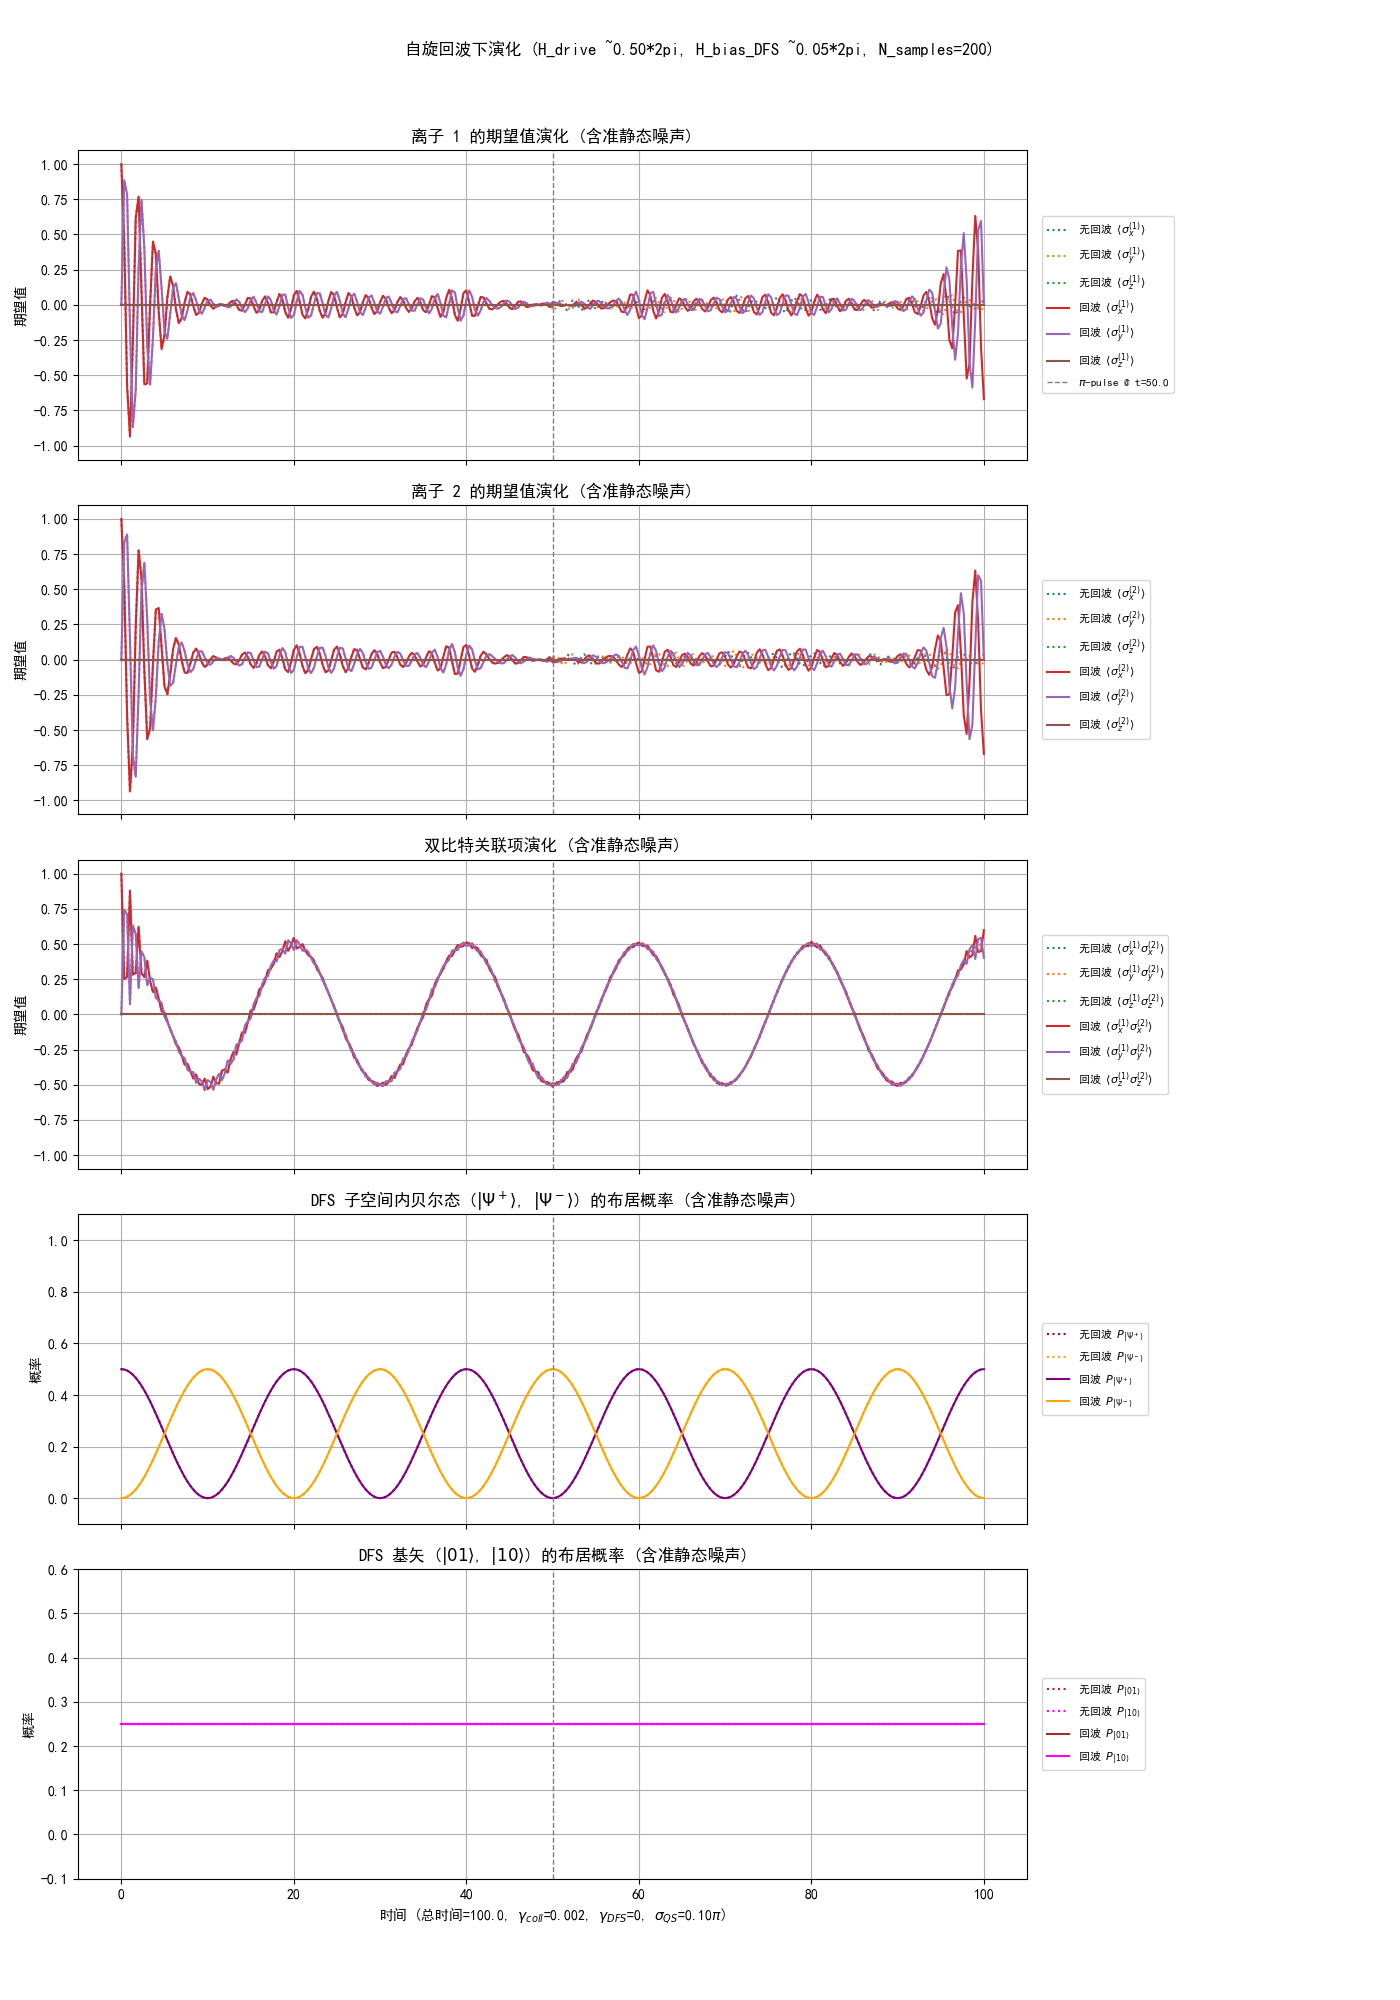


--- 期望值检查 (t=0, 基于平均结果) ---
初始 <sx1>: 1.0000 (理论: 1.0000)
初始 <sy1>: 0.0000 (理论: 0.0000)
初始 <sz1>: 0.0000 (理论: 0.0000)
初始 <sx2>: 1.0000 (理论: 1.0000)
初始 <sy2>: 0.0000 (理论: 0.0000)
初始 <sz2>: 0.0000 (理论: 0.0000)
初始 P(Psi+): 0.5000 (理论: 0.5000)
初始 P(Psi-): 0.0000 (理论: 0.0000)
初始 <sxsx>: 1.0000 (理论: 1.0000)
初始 <sysy>: 0.0000 (理论: 0.0000)
初始 <szsz>: 0.0000 (理论: 0.0000)
初始 P01: 0.2500 (理论: 0.2500)
初始 P10: 0.2500 (理论: 0.2500)


In [17]:
# --- 绘图 (与之前几乎相同，只是数据源改变) ---
fig, axes = plt.subplots(5, 1, figsize=(14, 20), sharex=True)

plot_linewidth = 1.5
plot_linestyle_no_echo = ':'
plot_linestyle_echo = '-'
pulse_line_color = 'gray'

# --- 预定义 LaTeX 字符串 (与之前相同) ---
tex_sx1 = r"$\langle \sigma_x^{(1)} \rangle$"
tex_sy1 = r"$\langle \sigma_y^{(1)} \rangle$"
tex_sz1 = r"$\langle \sigma_z^{(1)} \rangle$"
tex_sx2 = r"$\langle \sigma_x^{(2)} \rangle$"
tex_sy2 = r"$\langle \sigma_y^{(2)} \rangle$"
tex_sz2 = r"$\langle \sigma_z^{(2)} \rangle$"
tex_sxsx = r"$\langle \sigma_x^{(1)}\sigma_x^{(2)} \rangle$"
tex_sysy = r"$\langle \sigma_y^{(1)}\sigma_y^{(2)} \rangle$"
tex_szsz = r"$\langle \sigma_z^{(1)}\sigma_z^{(2)} \rangle$"
tex_P_psi_plus = r"$P_{|\Psi^+\rangle}$"
tex_P_psi_minus = r"$P_{|\Psi^-\rangle}$"
tex_P01 = r"$P_{|01\rangle}$"
tex_P10 = r"$P_{|10\rangle}$"


# --- 子图 0: 离子 1 演化 ---
ax = axes[0]
ax.plot(tlist_full, avg_result_no_echo_expect[0], label=f'无回波 {tex_sx1}', linestyle=plot_linestyle_no_echo, linewidth=plot_linewidth)
ax.plot(tlist_full, avg_result_no_echo_expect[1], label=f'无回波 {tex_sy1}', linestyle=plot_linestyle_no_echo, linewidth=plot_linewidth)
ax.plot(tlist_full, avg_result_no_echo_expect[2], label=f'无回波 {tex_sz1}', linestyle=plot_linestyle_no_echo, linewidth=plot_linewidth)
ax.plot(tlist_full, avg_results_echo_expect[0], label=f'回波 {tex_sx1}', linestyle=plot_linestyle_echo, linewidth=plot_linewidth)
ax.plot(tlist_full, avg_results_echo_expect[1], label=f'回波 {tex_sy1}', linestyle=plot_linestyle_echo, linewidth=plot_linewidth)
ax.plot(tlist_full, avg_results_echo_expect[2], label=f'回波 {tex_sz1}', linestyle=plot_linestyle_echo, linewidth=plot_linewidth)
ax.axvline(t_pulse_actual, color=pulse_line_color, linestyle='--', linewidth=1.0, label=f'$\pi$-pulse @ t={t_pulse_actual:.1f}')
ax.set_title('离子 1 的期望值演化 (含准静态噪声)')
ax.set_ylabel('期望值')
ax.legend(fontsize=8, loc='center left', bbox_to_anchor=(1.01, 0.5))
ax.grid(True)
ax.set_ylim([-1.1, 1.1])

# --- 子图 1: 离子 2 演化 ---
ax = axes[1]
ax.plot(tlist_full, avg_result_no_echo_expect[3], label=f'无回波 {tex_sx2}', linestyle=plot_linestyle_no_echo, linewidth=plot_linewidth)
ax.plot(tlist_full, avg_result_no_echo_expect[4], label=f'无回波 {tex_sy2}', linestyle=plot_linestyle_no_echo, linewidth=plot_linewidth)
ax.plot(tlist_full, avg_result_no_echo_expect[5], label=f'无回波 {tex_sz2}', linestyle=plot_linestyle_no_echo, linewidth=plot_linewidth)
ax.plot(tlist_full, avg_results_echo_expect[3], label=f'回波 {tex_sx2}', linestyle=plot_linestyle_echo, linewidth=plot_linewidth)
ax.plot(tlist_full, avg_results_echo_expect[4], label=f'回波 {tex_sy2}', linestyle=plot_linestyle_echo, linewidth=plot_linewidth)
ax.plot(tlist_full, avg_results_echo_expect[5], label=f'回波 {tex_sz2}', linestyle=plot_linestyle_echo, linewidth=plot_linewidth)
ax.axvline(t_pulse_actual, color=pulse_line_color, linestyle='--', linewidth=1.0)
ax.set_title('离子 2 的期望值演化 (含准静态噪声)')
ax.set_ylabel('期望值')
ax.legend(fontsize=8, loc='center left', bbox_to_anchor=(1.01, 0.5))
ax.grid(True)
ax.set_ylim([-1.1, 1.1])

# --- 子图 2: 双比特关联项 ---
ax = axes[2]
ax.plot(tlist_full, avg_result_no_echo_expect[8], label=f'无回波 {tex_sxsx}', linestyle=plot_linestyle_no_echo, linewidth=plot_linewidth)
ax.plot(tlist_full, avg_result_no_echo_expect[9], label=f'无回波 {tex_sysy}', linestyle=plot_linestyle_no_echo, linewidth=plot_linewidth)
ax.plot(tlist_full, avg_result_no_echo_expect[10], label=f'无回波 {tex_szsz}', linestyle=plot_linestyle_no_echo, linewidth=plot_linewidth)
ax.plot(tlist_full, avg_results_echo_expect[8], label=f'回波 {tex_sxsx}', linestyle=plot_linestyle_echo, linewidth=plot_linewidth)
ax.plot(tlist_full, avg_results_echo_expect[9], label=f'回波 {tex_sysy}', linestyle=plot_linestyle_echo, linewidth=plot_linewidth)
ax.plot(tlist_full, avg_results_echo_expect[10], label=f'回波 {tex_szsz}', linestyle=plot_linestyle_echo, linewidth=plot_linewidth)
ax.axvline(t_pulse_actual, color=pulse_line_color, linestyle='--', linewidth=1.0)
ax.set_title('双比特关联项演化 (含准静态噪声)')
ax.set_ylabel('期望值')
ax.legend(fontsize=8, loc='center left', bbox_to_anchor=(1.01, 0.5))
ax.grid(True)
ax.set_ylim([-1.1, 1.1])

# --- 子图 3: DFS 态概率 (Psi+ 和 Psi-) ---
ax = axes[3]
ax.plot(tlist_full, avg_result_no_echo_expect[6], label=f'无回波 {tex_P_psi_plus}', linestyle=plot_linestyle_no_echo, color='purple', linewidth=plot_linewidth)
ax.plot(tlist_full, avg_result_no_echo_expect[7], label=f'无回波 {tex_P_psi_minus}', linestyle=plot_linestyle_no_echo, color='orange', linewidth=plot_linewidth)
ax.plot(tlist_full, avg_results_echo_expect[6], label=f'回波 {tex_P_psi_plus}', color='purple', linestyle=plot_linestyle_echo, linewidth=plot_linewidth)
ax.plot(tlist_full, avg_results_echo_expect[7], label=f'回波 {tex_P_psi_minus}', color='orange', linestyle=plot_linestyle_echo, linewidth=plot_linewidth)
ax.axvline(t_pulse_actual, color=pulse_line_color, linestyle='--', linewidth=1.0)
ax.set_title(r'DFS 子空间内贝尔态 ($|\Psi^+\rangle$, $|\Psi^-\rangle$) 的布居概率 (含准静态噪声)')
ax.set_ylabel('概率')
ax.legend(fontsize=8, loc='center left', bbox_to_anchor=(1.01, 0.5))
ax.grid(True)
ax.set_ylim([-0.1, 1.1])

# --- 子图 4: DFS 基矢 |01> 和 |10> 的布居概率 ---
ax = axes[4]
ax.plot(tlist_full, avg_result_no_echo_expect[11], label=f'无回波 {tex_P01}', linestyle=plot_linestyle_no_echo, color='brown', linewidth=plot_linewidth)
ax.plot(tlist_full, avg_result_no_echo_expect[12], label=f'无回波 {tex_P10}', linestyle=plot_linestyle_no_echo, color='magenta', linewidth=plot_linewidth)
ax.plot(tlist_full, avg_results_echo_expect[11], label=f'回波 {tex_P01}', color='brown', linestyle=plot_linestyle_echo, linewidth=plot_linewidth)
ax.plot(tlist_full, avg_results_echo_expect[12], label=f'回波 {tex_P10}', color='magenta', linestyle=plot_linestyle_echo, linewidth=plot_linewidth)
ax.axvline(t_pulse_actual, color=pulse_line_color, linestyle='--', linewidth=1.0)
ax.set_title(r'DFS 基矢 ($|01\rangle$, $|10\rangle$) 的布居概率 (含准静态噪声)')
ax.set_xlabel(f'时间 (总时间={t_final:.1f}, $\gamma_{{coll}}$={gamma_collective_rate}, $\gamma_{{DFS}}$={gamma_DFS_dephasing_rate}, $\sigma_{{QS}}$={sigma_quasi_static_noise_strength/(np.pi):.2f}$\pi$)')
ax.set_ylabel('概率')
ax.legend(fontsize=8, loc='center left', bbox_to_anchor=(1.01, 0.5))
ax.grid(True)
ax.set_ylim([-0.1, 0.6])

fig.suptitle(f'自旋回波下演化 (H_drive ~{delta_drive_H/(2*np.pi):.2f}*2pi, H_bias_DFS ~{delta_omega_DFS/(2*np.pi):.2f}*2pi, N_samples={N_quasi_static_samples})', fontsize=12)
plt.tight_layout(rect=[0, 0.03, 0.85, 0.96])
plt.show()

# --- (期望值检查与之前相同, 但现在是基于平均后的初始值) ---
# 注意：理论初始值仍然是针对 rho_initial 的，不受准静态噪声在 t=0 的影响，
# 因为准静态噪声在哈密顿量中，不改变初始密度矩阵。
print("\n--- 期望值检查 (t=0, 基于平均结果) ---")
op_names = [
    "<sx1>", "<sy1>", "<sz1>",
    "<sx2>", "<sy2>", "<sz2>",
    "P(Psi+)", "P(Psi-)",
    "<sxsx>", "<sysy>", "<szsz>",
    "P01", "P10"
]
# 理论初始值计算 (如果初始态不是简单基态，最好用 expect 计算)
# psi_p_initial = (|g>+|e>)(|g>+|e>)/2 = 0.5 * (|00> + |01> + |10> + |11>)
# sx1 |00> = |10>, sx1 |01> = |11>, sx1 |10> = |00>, sx1 |11> = |01>
# <psi_p_initial | sx1 | psi_p_initial>
# = 0.25 * (<00|+<01|+<10|+<11|) (|10>+|11>+|00>+|01>)
# = 0.25 * (1+1+1+1) = 1  -- 理论上，如果初始态是 (+x)(+x)，则 <sx1> = <sx2> = 1
# 让我们用 qutip 计算理论初始值以确保准确性
rho_initial_for_check = psi_p_initial * psi_p_initial.dag()
theory_initial_values_calc = [expect(op, rho_initial_for_check) for op in e_ops_to_track]

for i, name in enumerate(op_names):
    sim_val_t0 = avg_result_no_echo_expect[i][0] # 取平均后的 t=0 值
    theory_val = theory_initial_values_calc[i]
    print(f"初始 {name}: {sim_val_t0:.4f} (理论: {theory_val:.4f})")